# Conversion of ONNX Model

## 🌟 Overview
In this tutorial, we'll go through converting a pre-trained ONNX model. We'll first download the model, test its inference, prepare it for deployment on a Luxonis device, and finally test it on a device.

## 📜 Table of Contents
- [🛠️ Installation](#installation)
- [🗃️ Model Download](#model-download)
- [✍ Model Test (Optional)](#model-test)
- [📦 NN Archive](#nn-archive)
- [🗂️ Archive](#archive)
- [🤖 Deploy](#deploy)
- [📷 DepthAI Script](#depthai-script)
- [🗂️ Export without Archive (Optional)](#onnx-export)

<a name="installation"></a>

## 🛠️ Installation

The main focus of this tutorial is using [`ModelConverter`](https://github.com/luxonis/modelconverter) for the conversion of a pre-trained model [`FFNet-40S`](https://huggingface.co/qualcomm/FFNet-40S) from `HuggingFace` models catalog to formats supported by Luxonis devices. `ModelConverter` is our open-source tool for converting all RVC Compiled Formats. Furthermore, we'll also use [`LuxonisML`](https://github.com/luxonis/luxonis-ml) since it provides us with functionality to generate a [`NN Archive`](https://rvc4.docs.luxonis.com/software/ai-inference/nn-archive/). Finally, we will use [`DepthAI v3`](https://rvc4.docs.luxonis.com/software/) and [`DepthaAI Nodes`](https://rvc4.docs.luxonis.com/software/ai-inference/depthai-nodes/) to run the converted model, process and visualize the results. So, let's not wait any longer and get straight to it!

In [ ]:
%pip install -q pillow opencv-python onnx onnxruntime modelconv@git+https://github.com/luxonis/modelconverter.git@main -U
%pip install --extra-index-url https://artifacts.luxonis.com/artifactory/luxonis-python-release-local/ depthai==3.0.0a8
%pip install -q depthai-nodes@git+https://github.com/luxonis/depthai-nodes.git@main -U

<a name="model-download"></a>

## 🗃️ Model Download

First, let's download the model from `torchvision`.

In [2]:
!wget https://huggingface.co/qualcomm/FFNet-40S/resolve/main/FFNet-40S.onnx -O ffnet40s.onnx

--2024-12-05 10:41:21--  https://huggingface.co/qualcomm/FFNet-40S/resolve/main/FFNet-40S.onnx
Resolving huggingface.co (huggingface.co)... 2600:9000:2127:a400:17:b174:6d00:93a1, 2600:9000:2127:4200:17:b174:6d00:93a1, 2600:9000:2127:9000:17:b174:6d00:93a1, ...
Connecting to huggingface.co (huggingface.co)|2600:9000:2127:a400:17:b174:6d00:93a1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/24/dd/24dd9b136055c353b4017684be83a7f24ece77b1f0c32b9667170290100e228b/930e356a5f797dc35763d0154cea5f16913572827fc0d859978ca3a8e3ddfa22?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27FFNet-40S.onnx%3B+filename%3D%22FFNet-40S.onnx%22%3B&Expires=1733650882&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczMzY1MDg4Mn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzI0L2RkLzI0ZGQ5YjEzNjA1NWMzNTNiNDAxNzY4NGJlODNhN2YyNGVjZTc3YjFmMGMzMmI5NjY3MTcwMjkwMTAwZTIyOGIvOTMwZTM1NmE1Zj

<a name="model-test"></a>

## ✍ Model Test (Optional)

It's a good practice to verify the performance of a source model that we want to convert to know that the model is working. This way, when the model is exported and isn't performing well on a device, we know that the problem must lie in the conversion process. 

Image Reference: Pixelwise Instance Segmentation with a Dynamically Instantiated Network - Scientific Figure on ResearchGate. Available from: https://www.researchgate.net/figure/Sample-results-on-the-Cityscapes-dataset-The-above-images-show-how-our-method-can-handle_fig5_315881952 [accessed 5 Dec 2024]

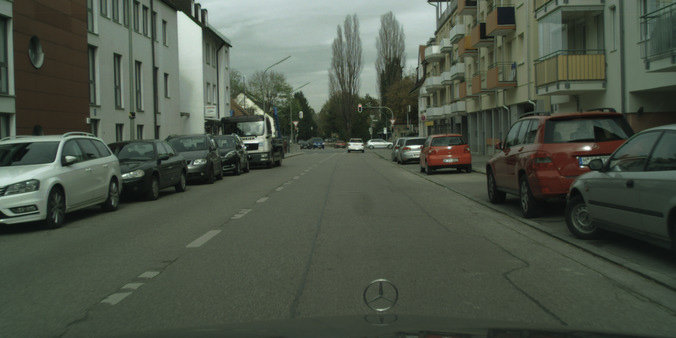

In [ ]:
import IPython

img_file = "media/city.jpg"

# Show the image
IPython.display.Image(img_file)

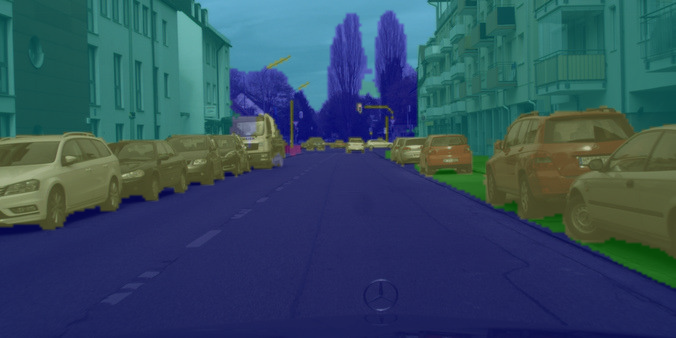

In [4]:
import cv2
import numpy as np
import onnxruntime as ort
import PIL
from PIL import Image


def normalize(img: np.ndarray, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
    """Normalizes the image"""
    img = img.astype(np.float64) / 255.0
    img = img - mean
    img = img / std
    return img


COLORS = [
    (128, 0, 0),  # class 1 - maroon
    (0, 128, 0),  # class 2 - green
    (128, 128, 0),  # class 3 - olive
    (0, 0, 128),  # class 4 - navy
    (128, 0, 128),  # class 5 - purple
    (0, 128, 128),  # class 6 - teal
    (128, 128, 128),  # class 7 - gray
    (64, 0, 0),  # class 8 - maroon
    (192, 0, 0),  # class 9 - red
    (64, 128, 0),  # class 10 - olive
    (192, 128, 0),  # class 11 - yellow
    (64, 0, 128),  # class 12 - navy
    (192, 0, 128),  # class 13 - fuchsia
    (64, 128, 128),  # class 14 - aqua
    (192, 128, 128),  # class 15 - silver
    (0, 64, 0),  # class 16 - green
    (128, 64, 0),  # class 17 - orange
    (0, 192, 0),  # class 18 - lime
    (128, 192, 0),  # class 19 - yellow
]

# Load the image
raw_image = cv2.imread(img_file)
image = cv2.resize(raw_image, (2048, 1024)).astype(np.float32)
image = normalize(image, mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225]))
image = image.transpose((2,0,1)) # HWC -> CHW
image = np.expand_dims(image, axis=0).astype(np.float32) # CHW -> NCHW

# Load the onnx model
ort_sess = ort.InferenceSession("ffnet40s.onnx")

# Run the inference
outputs = ort_sess.run(None, {'image': image})[0]
# Convert the output to masks
masks = np.argmax(outputs, axis=1)

# Create the mask
mask = np.zeros((masks.shape[1], masks.shape[2], 3), dtype=np.uint8)
for i in range(masks.shape[1]):
    for j in range(masks.shape[2]):
        mask[i,j] = COLORS[masks[0,i,j]]


# Plot the mask
mask = cv2.resize(mask, (raw_image.shape[1], raw_image.shape[0]))
mask = cv2.addWeighted(raw_image, 0.5, mask, 0.5, 0)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
# Visualize the mask
PIL.Image.fromarray(mask)


We have verified that the model returns reasonable predictions, so let's jump into the conversion.

<a name="nn-archive"></a>

## 📦 NN Archive

This section will introduce [`NN Archive`](https://rvc4.docs.luxonis.com/software/ai-inference/nn-archive/), what it is, and its benefit. `NN Archive` is our own format that packages the model executable(s) and configuration files into a .tar.xz archive. The primary purpose of the `NN Archive` is to describe and specify what the model expects as an input, what the model outputs, and lastly, if and how to process the result. The benefit of the `NN Archive` is seamless integration with our library ecosystem, especially the `DepthAI Nodes` package responsible for processing a model's output. Later in this tutorial, we will experience the benefit of this ourselves.

We will use functions from [`LuxonisML`](https://github.com/luxonis/luxonis-ml) to create the `NN Archive`. The `NN Archive` consists of two parts, model executables (e.g. `ONNX`, `OpenVINO IR`, `TFLite`) and a config encoding the scheme version and a dictionary describing a model's inputs, outputs, heads, and metadata sections. Let's briefly describe each section.

**Inputs**

This section describes all of the model's input(s) and their preprocessing. It's defined as a list of dictionaries. To check out all its fields, please visit our [documentation](https://rvc4.docs.luxonis.com/software/ai-inference/nn-archive/#NN%20Archive-Configuration-Inputs).

**Outputs**

This section specifies all the model's output(s). It's defined as a list of dictionaries containing the name and data type of the output data. For more information, refer to our [documentation](https://rvc4.docs.luxonis.com/software/ai-inference/nn-archive/#NN%20Archive-Configuration-Outputs).

**Head**

This section configures the post-processing steps applied to the model's output(s). It's again defined as a list of dictionaries. Please visit our [documentation](https://rvc4.docs.luxonis.com/software/ai-inference/nn-archive/#NN%20Archive-Configuration-Heads) to learn more about it.

**Metadata**

This section specifies the name of the model, the path to it, and the model's precision.


The creation of a `NN Archive` looks like this:

```python
from luxonis_ml.nn_archive.archive_generator import ArchiveGenerator
from luxonis_ml.nn_archive.config import CONFIG_VERSION


config = {
    "config_version": CONFIG_VERSION,       # Draw config version from luxonis-ml
    "model": {
        "metadata": { ... },                # Specify the model's metadata
        "inputs":   [ { ... }, ... ],       # Specify the model's input stream(s)
        "outputs":  [ { ... }, ... ],       # Specify the model's output stream(s)
        "heads":    [ { ... }, ... ],       # Specify all heads for the model
 }
}

generator = ArchiveGenerator(
    archive_name="...",                     # Name of the generated archive file
    save_path="...",                        # Path to the 
    cfg_dict=config,
    executables_paths=["..."]
)

generator.make_archive()                    # Archive file is saved to the specified save_path
```

<a name="archive"></a>

## 🗂️ Archive

Once we are satisfied with the model's performance, we want to prepare it for deployment on the device. We want to package this exported model into a `NN Archive` as described in the section above.

The code below creates the `NN Archive`.

In [5]:
from luxonis_ml.nn_archive import ArchiveGenerator
from luxonis_ml.nn_archive.config_building_blocks import (
    DataType,
    InputType,
)
from luxonis_ml.nn_archive.config import CONFIG_VERSION

# Define the configuration dictionary
config = {
    "config_version": CONFIG_VERSION, # draw config version from luxonis-ml
    "model": {
        "metadata": {
            "name": "ffnet40s",
            "path": "ffnet40s.onnx",
            "precision": DataType.FLOAT32
        },
        "inputs": [ # Specify all inputs to the model
            {
                "name": "image",  # Define the input tensor name
                "dtype": DataType.FLOAT32, # Define the input tensor data type
                "input_type": InputType.IMAGE, 
                "shape": [1, 3, 1024, 2048], # Define the input tensor shape
                "layout": "NCHW", # Define the input tensor order
                "preprocessing": {
                    "mean": [123.675, 116.28, 103.53], # Mean values for each channel applied during preprocessing
                    "scale": [58.395, 57.12, 57.375] # Scale values for each channel applied during preprocessing
                }
            }
        ],
        "outputs": [  # Specify all outputs from the model
            {
                "name": "mask", # Define the output tensor name
                "dtype": DataType.FLOAT32, # Define the output tensor data type
                "shape": [1, 19, 128, 256], # Define the output tensor shape
                "layout": "NCHW", # Define the input tensor order
            }
        ],
        "heads": [ # Specify all heads for the model
            {
                "parser": "SegmentationParser", # Define the parser to use from depthai-nodes
                "metadata": {
                    "postprocessor_path": None,
                    "classes": [
                        "road",
                        "sidewalk",
                        "building",
                        "wall",
                        "fence",
                        "pole",
                        "traffic light",
                        "traffic sign",
                        "vegetation",
                        "terrain",
                        "sky",
                        "person",
                        "rider",
                        "car",
                        "truck",
                        "bus",
                        "train",
                        "motorcycle",
                        "bicycle",
                    ],
                    "n_classes": 19,
                    "is_softmax": False
                },
                "outputs": ["mask"] # Define the output tensor to use for the head
            }
        ]
    }
}

archive = ArchiveGenerator(
    archive_name="ffnet40s", # Define string name of the generated archive.
    save_path="./", # Define string path to where you want to save the archive file.
    cfg_dict=config,
    executables_paths=["ffnet40s.onnx"], # Define a list of string paths to relevant model executables.
)
archive.make_archive()

'./ffnet40s.tar.xz'

<a name="deploy"></a>

## 🤖 Deploy

Now that we have successfully archived the model, we aim to deploy it to the Luxonis device. The model's specific format depends on the Luxonis device series you have. We will show you how to use our [`ModelConverter`](https://github.com/luxonis/modelconverter) to convert the model as simply as possible. 


In [ ]:
!modelconverter hub login

To convert the model, we can use either CLI or Python API. We'll show both options but use the latter. For more details, please look [here](https://github.com/luxonis/modelconverter?tab=readme-ov-file#online-usage).

The call below will create a new model card inside your team on `HubAI` with the model file and details uploaded. It will further convert the model on the cloud to the selected target platform (e.g. [`RVC2`](https://rvc4.docs.luxonis.com/hardware/platform/rvc/rvc2/), [`RVC4`](https://rvc4.docs.luxonis.com/hardware/platform/rvc/rvc4/)) and download the converted model to your device. Choosing the target is as simple as setting a `target` argument in the `convert` function or using: 

- `modelconverter hub convert rvc2 ...` or
- `modelconverter hub convert rvc4 ...`.

Besides this, there are some platform-specific parameters. To check them out, please visit our [documentation](https://rvc4.docs.luxonis.com/software/ai-inference/conversion/rvc-conversion/offline/modelconverter/#ModelConverter-Parameters-Platform-Specific).

In [ ]:
from modelconverter import convert

# =============================================================================
# RVC2 conversion
# =============================================================================
converted_model = convert(
    "rvc2", 
    path="ffnet40s.tar.xz",
    name="FFNet-40S",
    description_short="Pretrained FFNet-40S on CityScapes",
    tasks=["SEGMENTATION"],
    license_type="MIT",
    is_public=False
)

# Equivalent command using the CLI
# !modelconverter hub convert rvc2 --path "ffnet40s.tar.xz" \
#                                 --name "FFNet-40S" \
#                                 --description-short "Pretrained FFNet-40S on CityScapes" \
#                                 --tasks "SEGMENTATION" \
#                                 --license-type "MIT" \
#                                 --no-is-public

# =============================================================================
# RVC4 conversion
# =============================================================================
# converted_model = convert(
#     "rvc4", 
#     path="ffnet40s.tar.xz",
#     name="FFNet-40S",
#     description_short="Pretrained FFNet-40S on CityScapes",
#     tasks=["SEGMENTATION"],
#     license_type="MIT",
#     target_precision="FP16",
#     is_public=False
# )

# Equivalent command using the CLI
# !modelconverter hub convert rvc4 --path "ffnet40s.tar.xz" \
#                                 --name "FFNet-40S" \
#                                 --description-short "Pretrained FFNet-40S on CityScapes" \
#                                 --tasks "SEGMENTATION" \
#                                 --license-type "MIT" \
#                                 --target-precision "FP16" \
#                                 --no-is-public

Model 'FFNet-40S' created with ID '3d905f99-397d-4044-ac60-8942b1e09dd6'

Model variant 'FFNet-40S 1024x2048' created with ID 'a5df8d95-671a-4f83-b13b-226abf9d9f10'

Model instance 'FFNet-40S 1024x2048 base instance' created with ID '410e86f0-94d1-4d48-b609-89774fc2d58e'

File 'ffnet40s.tar.xz' uploaded to model instance '410e86f0-94d1-4d48-b609-89774fc2d58e'

Model instance 'FFNet-40S 1024x2048 exported to rvc2' created for rvc2 export with ID 
'371d86ea-f221-4fa4-aabd-954c5e17b05b'

/Users/jancuhel/miniconda3/envs/luxonis-tutorials/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Donwloaded 'ffnet-40s-1024x2048-exported-to-rvc2/ffnet40s.rvc2.tar.xz'

We can see for ourselves that this call really created a new model card on `HubAI` with the exported model.

<img src="./media/ffnet_model_exported.png" alt="Exported model on HubAI" width="800">

**(Optional)** We'll now show you how to convert the model to another platform. The process is very similar to the one we used before. However, since the command above already created a model card for our model, we will use it by setting the `model-id`.

In [ ]:
# =============================================================================
# RVC2 conversion
# =============================================================================
# converted_model = convert(
#     "rvc2", 
#     path="ffnet40s.tar.xz",
#     name="FFNet-40S",
#     model_id="3d905f99-397d-4044-ac60-8942b1e09dd6"
# )

# Equivalent command using the CLI
# !modelconverter hub convert rvc2 --path "ffnet40s.tar.xz" \
#                                 --name "FFNet-40S" \
#                                 --model-id "3d905f99-397d-4044-ac60-8942b1e09dd6"

# =============================================================================
# RVC4 conversion
# =============================================================================
converted_model = convert(
    "rvc4",
    path="ffnet40s.tar.xz",
    name="FFNet-40S",
    model_id="3d905f99-397d-4044-ac60-8942b1e09dd6",
    target_precision="FP16"
)

# Equivalent command using the CLI
# !modelconverter hub convert rvc4 --path "ffnet40s.tar.xz" \
#                                 --name "FFNet-40S" \
#                                 --model-id "3d905f99-397d-4044-ac60-8942b1e09dd6" \
#                                 --target-precision "FP16"

Model variant 'FFNet-40S 1024x2048' created with ID 'a38a3f95-4db1-49ac-bcde-c9dde7dc9f3d'

Model instance 'FFNet-40S 1024x2048 base instance' created with ID '84de61eb-9a52-4f94-bb9f-24d885230fad'

File 'ffnet40s.tar.xz' uploaded to model instance '84de61eb-9a52-4f94-bb9f-24d885230fad'

Model instance 'FFNet-40S 1024x2048 exported to rvc4' created for rvc4 export with ID 
'76843011-efae-4282-b21a-14c37e6f0ed4'

/Users/jancuhel/miniconda3/envs/luxonis-tutorials/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Donwloaded 'ffnet-40s-1024x2048-exported-to-rvc4/ffnet40s.rvc4.tar.xz'

We have successfully converted our model for RVC2 and RVC4 devices, so let's test it on the camera! Please copy the path to the downloaded archive with the converted model from the output log of the appropriate code cell; we will use it in the next section.

In [10]:
MODEL_PATH = "ffnet-40s-1024x2048-exported-to-rvc2/ffnet40s.rvc2.tar.xz"

To check out other possible ways to convert your model for our devices, please refer to our [documentation](https://rvc4.docs.luxonis.com/software/ai-inference/conversion/rvc-conversion/).

<a name="depthai-script"></a>

## 📷 DepthAI Script

To test our model on one of our cameras, we need to have `DepthAI v3` and `Depthai Nodes` installed. Moreover, the following script must be run locally and requires a Luxonis device connected to your machine.

Please select the correct image type depending on the target platform you want to test.

In [ ]:
import depthai as dai

img_frame_type = dai.ImgFrame.Type.BGR888p # RVC2
# img_frame_type = dai.ImgFrame.Type.BGR888i # RVC4

Here is the script to run the model on the DepthAI device:

In [ ]:
import cv2
import depthai as dai
from depthai_nodes import ParsingNeuralNetwork
from depthai_nodes.ml.messages import SegmentationMask
import numpy as np
from typing import List, Tuple


COLORS = [
    (128, 0, 0),  # class 1 - maroon
    (0, 128, 0),  # class 2 - green
    (128, 128, 0),  # class 3 - olive
    (0, 0, 128),  # class 4 - navy
    (128, 0, 128),  # class 5 - purple
    (0, 128, 128),  # class 6 - teal
    (128, 128, 128),  # class 7 - gray
    (64, 0, 0),  # class 8 - maroon
    (192, 0, 0),  # class 9 - red
    (64, 128, 0),  # class 10 - olive
    (192, 128, 0),  # class 11 - yellow
    (64, 0, 128),  # class 12 - navy
    (192, 0, 128),  # class 13 - fuchsia
    (64, 128, 128),  # class 14 - aqua
    (192, 128, 128),  # class 15 - silver
    (0, 64, 0),  # class 16 - green
    (128, 64, 0),  # class 17 - orange
    (0, 192, 0),  # class 18 - lime
    (128, 192, 0),  # class 19 - yellow
]


def visualize_segmentation(frame: np.ndarray, message: SegmentationMask, colors: List[Tuple[int, int, int]] = COLORS) -> bool:
    """
    Visualize the segmentation mask on the frame
    :param frame: The frame to visualize the segmentation mask on
    :param message: The segmentation mask message
    :return: True if the user pressed "q", False otherwise
    """
    mask = message.mask
    mask = mask.reshape(mask.shape[0], mask.shape[1])
    frame = cv2.resize(frame, (mask.shape[1], mask.shape[0]))

    colormap = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for class_id, color in enumerate(colors):
        m = mask == class_id
        colormap[m] = color

    alpha = 0.5
    overlay = cv2.addWeighted(colormap, alpha, frame, 1 - alpha, 0)

    cv2.imshow("Segmentation", overlay)

    if cv2.waitKey(1) == ord("q"):
        cv2.destroyAllWindows()
        return True
    
    return False


with dai.Pipeline() as pipeline:
    cam = pipeline.create(dai.node.Camera).build()
    nn_archive = dai.NNArchive(MODEL_PATH)
    # Create the neural network node
    nn_with_parser = pipeline.create(ParsingNeuralNetwork).build(
        cam.requestOutput((2048, 1024), type=img_frame_type, fps=30), 
        nn_archive
    )
    # Create output queues
    parser_output_queue = nn_with_parser.out.createOutputQueue()
    frame_queue = nn_with_parser.passthrough.createOutputQueue()

    # # Start pipeline
    pipeline.start()

    while pipeline.isRunning():
        # Get the frame
        frame: dai.ImgFrame = frame_queue.get().getCvFrame()
        # Get the parsed message containing the segmentation mask
        parser_msg: dai.ImgFrame = parser_output_queue.get()
        if visualize_segmentation(frame, parser_msg):
            pipeline.stop()
            break

<a name="onnx-export"></a>

## 🗂️ Export without Archive (Optional)

It is also possible to skip the model archiving and convert the model straight from `ONNX.` However, when running the model on the device, we'd need to define parsers and other parameters manually, so we recommend first creating the `NN Archive` and then converting the model.

In [ ]:
from modelconverter import convert

converted_model = convert(
    "rvc2", 
    path="ffnet40s.onnx",
    name="FFNet-40S ONNX",
    description_short="Pretrained FFNet-40S on CityScapes",
    tasks=["SEGMENTATION"],
    license_type="MIT",
    is_public=False
)

Yay! 🎉🎉🎉 Huge congratulations, you have successfully finished this tutorial in which you deployed a pre-trained `FFNet-40S` segmentation model to our cameras!